In [1]:
#!pip install geopy
#!pip install python-google-places
%matplotlib inline
import pandas as pd
from datetime import datetime
from geopy.distance import geodesic
import geopy.distance
from geopy.distance import vincenty as VIN
from geopy.distance import great_circle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pylab as plot
from sklearn.linear_model import LinearRegression
from sklearn import datasets
import statsmodels.formula.api as sm

In [2]:
data = pd.read_csv("unique_mls_db_GIT.csv")
cpi=pd.read_csv("CPI.csv")

#coordinates of major go train stations in mississauga and nearby cities: Lisgar, Meadowvale, Streesville, _
#Erindale, Cocksville, Dixie, Kipling, Clarkson, Port Credit, and Long Branch

go_station_msga=[[43.5905809,-79.788362],[43.5976,-79.75369999999998],
                 [43.5762,-79.70910000000003],[43.5670973,-79.6689102],
                 [43.5819,-79.62369999999998],[43.607605,-79.5776749],
                 [43.6357039,-79.5372283],[43.51251816552179,-79.63435649871826],
                 [43.5555,-79.5874],[43.59133291164543,-79.54609036445617]]

#coordinates of major hospitals in mississauga: Trillium Health Centre, Mississauga Credit Valley Hospital, _
#Oakville Trafalgar Memorial Hospital, Milton District Hospital

hospitals_msga = [[43.5713, -79.6084],[43.5594, -79.7033],[43.4507, -79.7639],[43.4962539,-79.8716229]]

data_msga = data.loc[data['city']=='Mississauga']

In [3]:
#Categorize house types: 1 = town house, 2 = detached, 3 = semi-detached, 4 = condo; 
#Drop the remaining house types including vacant land, link house, mobile trailer etc. 

house_types = {'Att/Row/Twnhouse':1, 'Condo Townhouse':1,'Det W/Com Elements':2,'Detached':2,'Semi-Det Condo':3,
               'Semi-Detached':3,'Comm Element Condo':4,'Condo Ap':4,'Condo Apartment':4,'Condo Apt':4,
               'Condo To':4,'Det Condo':4,'Leasehold Condo':4,}

data_msga['house_type'] = data_msga['type'].map(house_types)
data_msga=data_msga.dropna(subset=['house_type'])

#---------------------------------------------------------------------------------------------------------------------
#any fee associated with a house: 1 = free hold, 2 = not free hold

house_fees = {'house':1, 'condo':2}

data_msga['house_fees'] = data_msga['house_condo'].map(house_fees)

#---------------------------------------------------------------------------------------------------------------------
#area in mississauga where a house belongs to

house_area = {'Streetsville':1, 'Cooksville':2,'Applewood':3,'Rathwood':4,'Hurontario':5,'Central Erin Mills':6,
              'Mineola':7,'Clarkson':8,'City Centre':9,'Meadowvale':10,'Malton':11,'Erin Mills':12,
              'Churchill Meadows':13,'Lisgar':14,'Port Credit':15,'East Credit':16,'Creditview':17,
              'Meadowvale Village':18,'Lorne Park':19,'Fairview':20,'Mississauga Valleys':21,'Erindale':22,
              'Sheridan':23,'Dixie':24,'Northeast':25,'Mavis-Erindale':26,'Gateway':27,'Lakeview':33,
              'Meadowvale Business Park':28,'Sheridan Park':29,'Southdown':30,'Port Credi':31,'City Centr':32,
              'Huttonville':34}    
    
data_msga['house_area'] = data_msga['area'].map(house_area)

c:\users\zhaojoseph\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
#add soldyear, soldmonth columns on both CPI and housing data in preparation for merging these two files
data_msga.loc[:,['solddate']] = pd.to_datetime(data_msga['solddate'])
data_msga.insert(len(data_msga.columns),column='soldyear',value=pd.DatetimeIndex(data_msga['solddate']).year)
data_msga.insert(len(data_msga.columns),column='soldmonth',value=pd.DatetimeIndex(data_msga['solddate']).month)
cpi_targetrange=cpi[(pd.to_datetime(cpi['Date'])>=datetime(2015,7,1)) & 
                    (pd.to_datetime(cpi['Date'])<=datetime(2017,6,30))]
cpi_targetrange.insert(len(cpi_targetrange.columns),column='soldyear',
                       value=pd.DatetimeIndex(cpi_targetrange['Date']).year)
cpi_targetrange.insert(len(cpi_targetrange.columns),column='soldmonth',
                       value=pd.DatetimeIndex(cpi_targetrange['Date']).month)

#merge with CPI file and convert nominal sold prices to real sold prices with base case = 2015-07-31 

data_msga=pd.merge(cpi_targetrange, data_msga, on=['soldyear','soldmonth'], how='outer')
cpibase=float(cpi_targetrange['PX_LAST'][pd.to_datetime(cpi_targetrange['Date'])==datetime(2015,7,31)])
data_msga.insert(len(data_msga.columns),column='cpibase',value=cpibase)
data_msga.insert(len(data_msga.columns),column='adjustedSoldPrice',value=
                round(data_msga['soldprice']*data_msga['cpibase']/data_msga['PX_LAST'],0))

In [53]:
#Categorize property selling seasonality based on soldmonth: 1 = summer (April to August), 2 = shoulder season
#(September to November), 3 = winter (December to March)

data_msga['season'] = ''
data_msga.loc[(data_msga.soldmonth<=8 ) & (data_msga.soldmonth >=4),'season']= 1
data_msga.loc[(data_msga.soldmonth<=11 ) & (data_msga.soldmonth >=9),'season']= 2
data_msga.loc[(data_msga.soldmonth==12 ) | (data_msga.soldmonth >=1) & (data_msga.soldmonth <=3),'season']= 3

In [6]:
#take a house's coordinates and calculate minimum distance of a house to GO stations and hospitals
data_msga_coordinate = data_msga[['latitude','longitude']].values
mindist_GO = []
mindist_Hospital = []
for i in range(len(data_msga_coordinate)):
    tempGO = []
    tempHospital = []
    for j in range(len(go_station_msga)):
        tempGO.append(geodesic(go_station_msga[j], data_msga_coordinate[i]).meters)
    mindist_GO.append(round(min(tempGO), 2))

    for k in range(len(hospitals_msga)):
        tempHospital.append(geodesic(hospitals_msga[k], data_msga_coordinate[i]).meters)
    mindist_Hospital.append(round(min(tempHospital),2))
        
#add the minimum distance to the dataframe

data_msga.insert(len(data_msga.columns),column='mindist_GO',value=mindist_GO)
data_msga.insert(len(data_msga.columns),column='mindist_Hospital',value=mindist_Hospital)

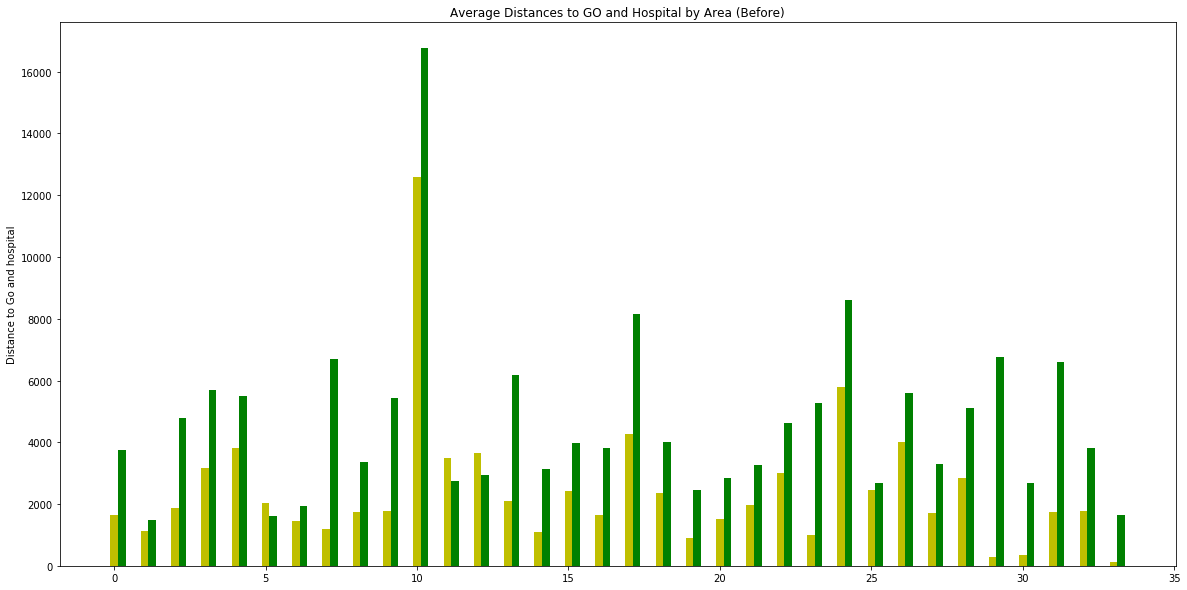

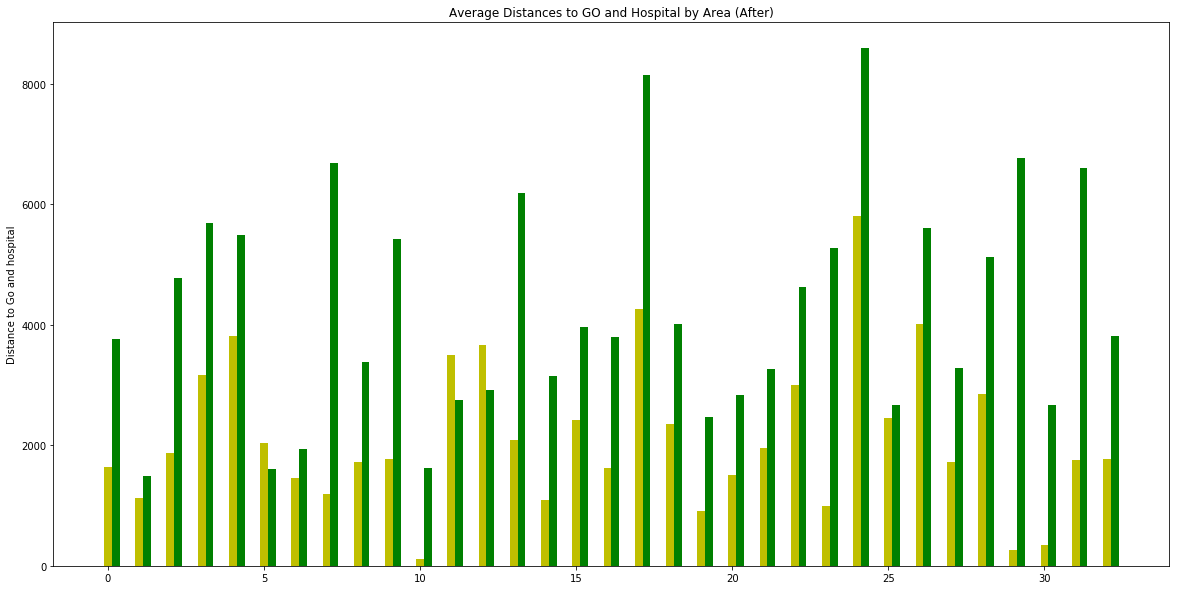

In [7]:
#the average distance between a nearest hospital/GO station and a house in Malton is significantly longer than in other
#area, which indicates that Malton should be removed from the model as a outliner

areamean = data_msga.groupby(['area']).mean()
areamean = areamean.sort_values(by=['house_area'])
n=np.arange(len(areamean.index))
width = 0.25
fig,ax=plt.subplots(figsize=(20,10))
mean_dis_GO = ax.bar(n,areamean['mindist_GO'],width,color='y',align='center')
mean_dis_hospital = ax.bar(n+width,areamean['mindist_Hospital'],width,color='g',align='center')
ax.set(ylabel = 'Distance to Go and hospital',title='Average Distances to GO and Hospital by Area (Before)')
plt.show()

#exclude Malton, and replace group 11 (Malton) with the last grup 34
data_msga=data_msga[data_msga['area']!='Malton']
data_msga.house_area[data_msga.house_area==34] = 11

areamean = data_msga.groupby(['area']).mean()
areamean = areamean.sort_values(by=['house_area'])
n=np.arange(len(areamean.index))
width = 0.25
fig,ax=plt.subplots(figsize=(20,10))
mean_dis_GO = ax.bar(n,areamean['mindist_GO'],width,color='y',align='center')
mean_dis_hospital = ax.bar(n+width,areamean['mindist_Hospital'],width,color='g',align='center')
ax.set(ylabel = 'Distance to Go and hospital',title='Average Distances to GO and Hospital by Area (After)')
plt.show()

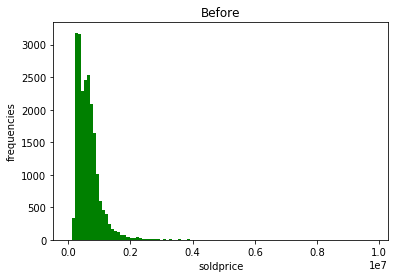

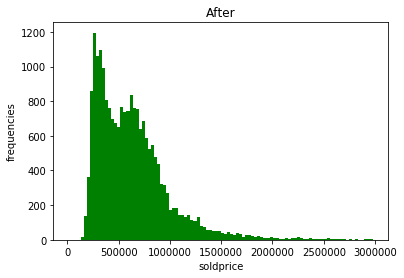

In [8]:
#exclude house sold at zero price 
#exclude outliner that were sold at more than 3 billion 

data_msga=data_msga[data_msga['adjustedSoldPrice']!=0]
n,bins,patches=plt.hist(data_msga['adjustedSoldPrice'],100,facecolor='g')
plt.xlabel('soldprice')
plt.ylabel('frequencies')
plt.title('Before')
plot.show()
data_msga=data_msga[data_msga['adjustedSoldPrice']<3000000]

n,bins,patches=plt.hist(data_msga['adjustedSoldPrice'],100,facecolor='g')
plt.xlabel('soldprice')
plt.ylabel('frequencies')
plt.title('After')
plot.show()

In [9]:
#scale the minimum distance to GO station and hospital to the range of 1 to 100 to avoid these two variables dominate 
#the other values, which are no bigger than 35

data_msga.insert(len(data_msga.columns),column='mindist_GO_min',value=data_msga['mindist_GO'].min())
data_msga.insert(len(data_msga.columns),column='mindist_GO_max',value=data_msga['mindist_GO'].max())
data_msga.insert(len(data_msga.columns),column='mindist_Hospital_min',value=data_msga['mindist_Hospital'].min())
data_msga.insert(len(data_msga.columns),column='mindist_Hospital_max',value=data_msga['mindist_Hospital'].max())

data_msga.insert(len(data_msga.columns),column='mindist_GO_score',
                 value=100*(data_msga['mindist_GO_max']-data_msga['mindist_GO'])/
                 (data_msga['mindist_GO_max']-data_msga['mindist_GO_min']))
data_msga.insert(len(data_msga.columns),column='mindist_Hospital_score',
                 value=100*(data_msga['mindist_Hospital_max']-data_msga['mindist_Hospital'])/
                 (data_msga['mindist_Hospital_max']-data_msga['mindist_Hospital_min']))

In [59]:
#file for modeling
y = data_msga['adjustedSoldPrice']
data_msga_final = data_msga[{'mindist_GO_score','mindist_Hospital_score','season','house_type',
                           'house_fees','house_area','bdrm','wshrm'}]
x=data_msga_final.values
result = sm.OLS(y,x).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      adjustedSoldPrice   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 2.511e+04
Date:                Mon, 08 Apr 2019   Prob (F-statistic):               0.00
Time:                        01:36:32   Log-Likelihood:            -2.9127e+05
No. Observations:               21199   AIC:                         5.826e+05
Df Residuals:                   21191   BIC:                         5.826e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.189e+05   2017.783     58.918      0.000    1.15e+05    1.23e+05
x2         -9722.0507   1629.664     -5.966      0.000   -1.29e+04   -6527.786
x3          9318.0127   1821.693      5.115      0.000    5747.357    1.29e+04
x4          1752.0443    226.416      7.738      0.000    1308.252    2195.837
x5          5.129e+04   2569.890     19.959      0.000    4.63e+04    5.63e+04
x6          4273.4173    198.924     21.483      0.000    3883.511    4663.323
x7         -2.655e+05   4124.690    -64.373      0.000   -2.74e+05   -2.57e+05
x8          2165.5395    208.362     10.393      0.000    1757.134    2573.945
==============================================================================
Omnibus:                    11300.268   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           123406.766
Skew:                           2.343   Prob(JB):                         0.00
Kurtosis:                      13.852   Cond. No.                         342.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""